In [199]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid',{'grid.linestyle': u'--','grid.color': '.9'})
%matplotlib inline

## Simulation of Langevin Process

### 1. Langevin dynamic

$$
dX_t = -\nabla V(X_t) dt + \sqrt{2\beta^{-1}}dW_t
$$

with cannical distribution

$$
\mu(dx) = Z^{-1} \exp\big(-\beta V(x)\big)dx
$$

we start by a toy example:

$\beta = 1$ and $V(x) = x^4 - 2x^2$.


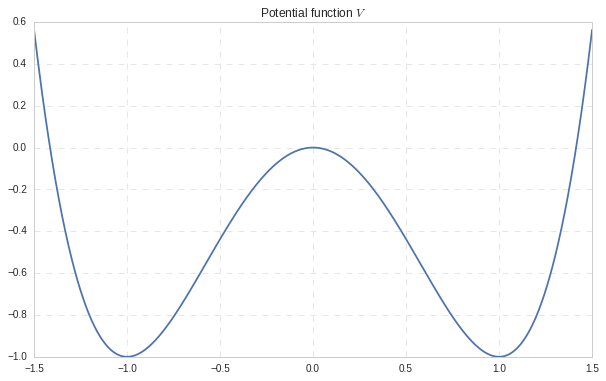

In [200]:
plt.figure(figsize = (10,6))
x = np.linspace(-1.5,1.5,1000)
plt.plot(x, x**4-2*x**2)
plt.title('Potential function $V$')

In [202]:
def ULA_update(X, dt, beta = 1.):
    """
    this function defines a non-homogenerous markov transition kernel
    for unadjusted Langevin dynamics
    """
    Y = np.sqrt(2 * dt / beta) * np.random.normal(0,1,1) + X - 4 * (X ** 3 - X) * dt
    return Y


In [203]:
def sim_process(X_0, X_update, N = 10, dt = 0.1, beta = 1.):
    
    X_sim = [X_0]
    for i in range(N):
        X_sim = np.append(X_sim, X_update(X_sim[i],dt, beta))
    return X_sim
    

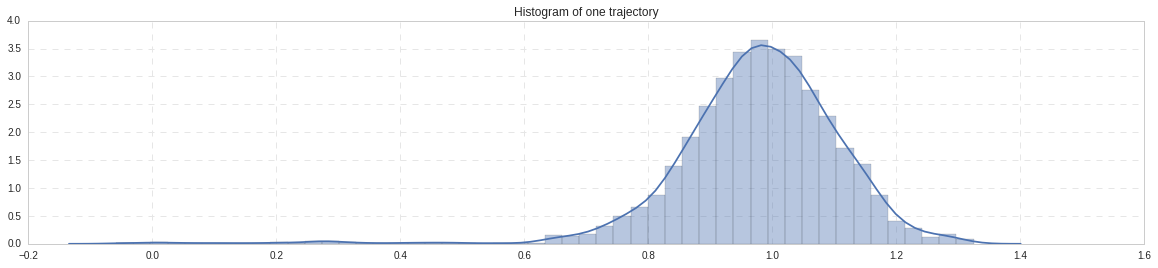

In [211]:
plt.figure(figsize = (20,4))
sns.distplot(sim_process(0,ULA_update, N = 5000, dt = 0.01, beta = 10), bins = 50)
plt.title('Histogram of one trajectory')

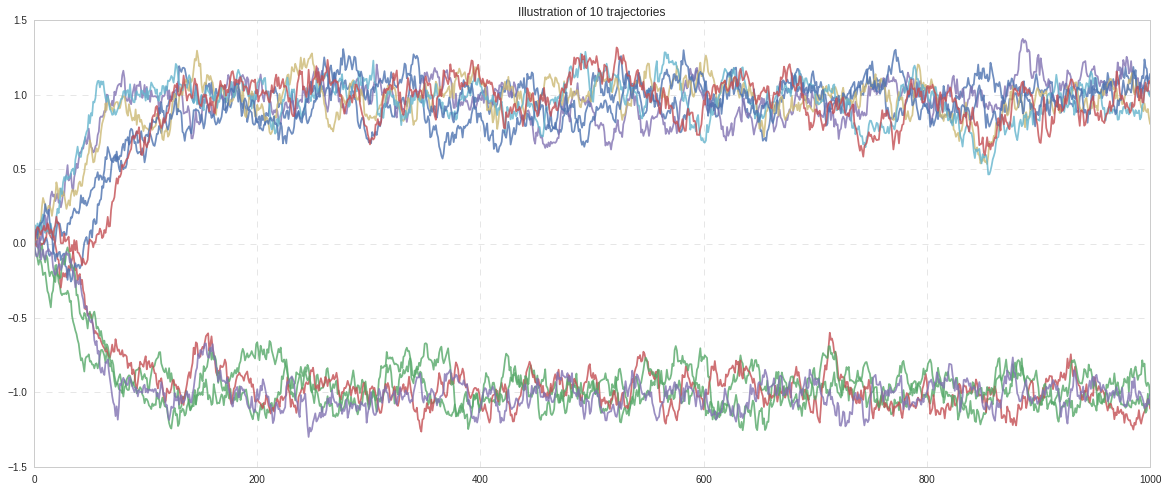

In [210]:
plt.figure(figsize = (20,8))
for i in range(10):
    plt.plot(sim_process(0,ULA_update, N = 1000, dt = 0.01, beta = 10), linestyle = '-', alpha = 0.8)
plt.title('Illustration of 10 trajectories')

## AMS Illustration

We let
$$A = \{-1\}\text{ and } B = \{1\}$$
and reaction coordinate
$$\xi(x) = x$$
We are the interested by the probability
$$q (x)  =  \mathbf{P}\big( X_t^x\text{ reaches $B$ before return to $A$}\big)$$
Particularly, to simply the problem, we will concentrate on estimating $q(0)$.

In [315]:
def X_evolution(init, X_update, dt = 0.1, beta = 1.):
    
    X_sim = [init, X_update(init,dt, beta)]
    k = 1
    while (np.abs(X_sim[k] - 1) >= dt) * (np.abs(X_sim[k] + 1) >= dt) == 1:
        X_sim = np.append(X_sim, X_update(X_sim[k],dt, beta))
        k += 1
    return np.array(X_sim)
    

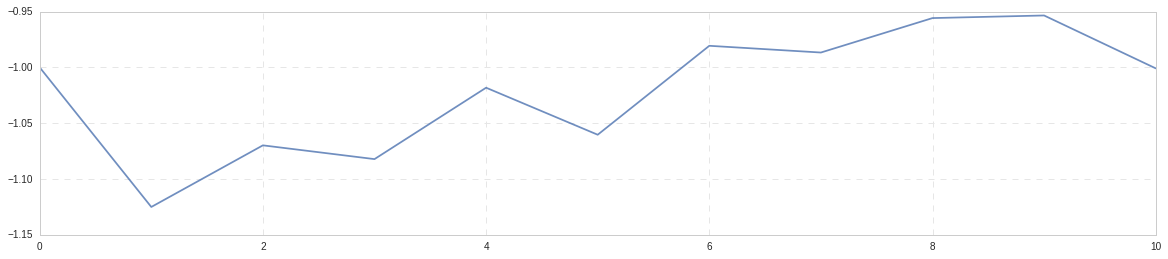

In [548]:
plt.figure(figsize = (20,4))
plt.plot(X_evolution(-1,ULA_update, dt = 0.01, beta = 10), linestyle = '-', alpha = 0.8)

In [570]:
class replica:
    def __init__(self, init = -1,update = ULA_update, X_evolution = X_evolution, dt = 0.01, beta = 10.):
        self.dt = dt
        self.beta = beta
        self.evolution = X_evolution
        self.traj = X_evolution(init,update, dt = dt, beta = beta) 
        self.value = np.max(self.traj)

X = replica(init = -1)

In [584]:
replica(init = -1).value

-0.74354768152786965

In [551]:
def S_test(X):
    '''
    score function which is a black box
    '''
    return X 

def mu_0_test(N):
    '''
    param n: the size of particles
    '''
    a = []
    for i in range(N):
        a += [replica(init = -1)]
    return a

X = mu_0_test(10)

In [644]:
from time import time


class RareEvents:
    def __init__(self, mu_0, score_function,
                 level, p_0 = 0.75, particle = replica):
        """
        :param level: level to estimate
        :param p_0: successful rate, the classical way is to choose p_0 large,
                    but for AMS, in order to fix the level, we would like to choose
                    p_0 small. This will also improve the quality of the variance 
                    estimator.
        :param mu_0: distribution of X_0
        :param score_function: black box score_function
        :param shaker: metro-polis/Gibbs/Gaussian(for the toy example) kernel
        """
        self.mu_0 = mu_0
        self.score_function = score_function
        self.level = level
        self.p_0 = p_0
        self.particle = replica

    def adaptive_levels(self,N, shake_times = 1, status_tracking = False):
        ###### Initiation
        t_0 = time()
        xi = []
        X = self.mu_0(N)
        xi += [[X[i].value for i in range(N)]]
        A = [] 
        
        p_0 = self.p_0
        L = np.array([-np.Inf,np.sort(self.score_function(np.array([X[i].value for i in range(N)])))[np.int((1-p_0)*N)]])
        k = 1
        #E = []
        #E += [range(N)]

        while(L[k]<self.level):
            I = []
            survive_index = []
            for i in range(N):
                if self.score_function(X[i].value)>L[k]:
                    #I += [X[i]]
                    #S_called_times += 1
                    survive_index += [i]
            ell = len(survive_index) 
           # to ensure that I_k would not be empty
            if ell == 0:        
                break

           # we remark that the permutation trick below doesn't work for the estimator of var

            #I = np.random.permutation(I)
            #q = 0
            #for i in clone_index:
            #    X[i] = I[q%ell]
            #    q += 1
            A_k = np.zeros(N,dtype = np.int) 
            X_cloned = [[] for ind in range(N)] 
            for i in range(N):
                A_k[i] = np.random.choice(survive_index)
                X_cloned[i] = X[A_k[i]]
            
            A += [A_k]   
            X = X_cloned

            for shake_ind in range(shake_times):
                for j in range(N):
                    X_iter = self.particle(init = L[k])
                    if self.score_function(X_iter.value)>L[k]:
                        X[j] = X_iter
            L = np.append(L, np.sort(self.score_function(np.array([X[i].value for i in range(N)])))[np.int((1-p_0)*N)])
            xi += [[X[i].value for i in range(N)]]
            k += 1
        n = k
        N_L = np.sum(self.score_function(np.array([X[i].value for i in range(N)]))>self.level)
        r_hat = N_L/float(N)
        p_hat = p_0**(n-1)*r_hat 

        if status_tracking ==True:
            print ("estimation of p: " + str(p_hat))
            print ('____________________________________________________________\n')
            print ("Time spent: %s s" %(time() - t_0) )
            print ('levels: ' + str(L))
            print ("r: " + str(r_hat))
            #print ("score_function called: %s times" % S_called_times)
        output = {'p_hat':p_hat,  \
                  'A':A,\
                  'xi':xi,\
                 }    
        return output
    

In [657]:
####### parameters #######
N_test = 500 
p_0_test = 0.2
shake_times = 1 
level_test = 0.9 
test_info = '|num_particles_' + str(N_test) 
        
################################################################################


####### definition of the RareEvents class
rare_test = RareEvents(mu_0 = mu_0_test, score_function = S_test,\
level = level_test, p_0 = p_0_test)

#test
test_result = rare_test.adaptive_levels(N = N_test, shake_times = shake_times, status_tracking=True)
#tracing the genealogical information
A = test_result['A']
xi = test_result['xi']


estimation of p: 1.03936e-05
____________________________________________________________

Time spent: 6.47152304649 s
levels: [       -inf -0.87400001 -0.70343638 -0.58555015 -0.47379998 -0.34678866
 -0.18565617  0.10616678  1.07824822]
r: 0.812
